### Import required library and packages

In [1]:
import os
import numpy as np
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
import matplotlib.pyplot as plt
from tqdm import tqdm
import urllib
import IPython

## Build UNet Architecture

In [2]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [3]:
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

In [4]:
def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [5]:
def build_unet(input_shape):
    inputs = Input(input_shape)

    """ Encoder """
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    b1 = conv_block(p4, 1024)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    """ Output """
    outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    return Model(inputs, outputs, name="U-Net")

In [6]:
def load_data(dataset_path):
    images = sorted(glob(os.path.join(dataset_path, "images/*")))
    masks = sorted(glob(os.path.join(dataset_path, "masks/*")))
    train_x, test_x = train_test_split(images, test_size=0.2, random_state=42)
    train_y, test_y = train_test_split(masks, test_size=0.2, random_state=42)
    return (train_x, train_y), (test_x, test_y)

In [7]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (256, 256))
    x = x/255.0
    x = x.astype(np.float32)
    # (256, 256, 3)
    return x

In [8]:
def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

In [9]:
def preprocess(image_path, mask_path):
    def f(image_path, mask_path):
        image_path = image_path.decode()
        mask_path = mask_path.decode()
        x = read_image(image_path)
        y = read_mask(mask_path)
        return x, y
    image, mask = tf.numpy_function(f, [image_path, mask_path], [tf.float32, tf.float32])
    image.set_shape([256, 256, 3])
    mask.set_shape([256, 256, 1])
    return image, mask

In [10]:
def tf_dataset(images, masks, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    return dataset

### Train the model

In [32]:
""" Hyperparameters """
dataset_path = "../input/person-segmentation/people_segmentation"
input_shape = (256, 256, 3)
batch_size = 8
epochs = 1
lr = 1e-4
model_path = "./unet.h5"
csv_path = "./data.csv"

""" Loading the dataset """
(train_x, train_y), (test_x, test_y) = load_data(dataset_path)

train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(test_x, test_y, batch=batch_size)

""" Model """
model = build_unet(input_shape)
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(lr),
    metrics=[
        tf.keras.metrics.MeanIoU(num_classes=2),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision()
    ]
)

callbacks = [
    ModelCheckpoint(model_path, monitor="val_loss", verbose=1),
    ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.1, verbose=1),
    CSVLogger(csv_path),
    EarlyStopping(monitor="val_loss", patience=10)
]

train_steps = len(train_x)//batch_size
if len(train_x) % batch_size != 0:
    train_steps += 1
    
valid_steps = len(test_x)//batch_size
if len(test_x) % batch_size != 0:
    valid_steps += 1

model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs = epochs,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

568/568 [==============================] - 347s 607ms/step - loss: 0.3764 - mean_io_u_1: 0.3722 - recall_1: 0.6178 - precision_1: 0.6979 - val_loss: 0.4655 - val_mean_io_u_1: 0.3721 - val_recall_1: 0.8002 - val_precision_1: 0.5855

Epoch 00001: saving model to ./unet.h5


### Test the model

  0%|          | 0/1 [00:00<?, ?it/s]

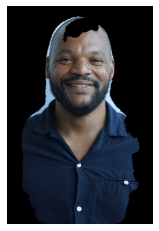

100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


In [39]:
import numpy as np
import cv2
import tensorflow as tf
from tqdm import tqdm
import os
import matplotlib.pyplot as plt  # Добавляем для отображения изображений

# Список путей к изображениям
test_images = [
    '/kaggle/input/111111/833499.jpg' 
]

# Загрузка модели
model = tf.keras.models.load_model("./unet.h5")

for path in tqdm(test_images, total=len(test_images)):
    # Чтение изображения с диска
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    original_image = x
    h, w, _ = x.shape
    
    # Предобработка изображения
    x = cv2.resize(x, (256, 256))
    x = x / 255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)

    # Предсказание маски
    pred_mask = model.predict(x)[0]
    pred_mask = cv2.resize(pred_mask, (w, h))
    pred_mask = np.expand_dims(pred_mask, axis=-1)
    pred_mask = pred_mask > 0.5

    # Создание маски фона
    background_mask = np.abs(1 - pred_mask)

    # Применение маски к изображению
    masked_image = original_image * pred_mask

    # Создание черного фона для фоновой маски
    background_mask = np.concatenate([background_mask, background_mask, background_mask], axis=-1)
    background_mask = background_mask * [0, 0, 0]


    # Комбинирование изображения и фона
    masked_image = masked_image + background_mask

    # Преобразование изображения в формат uint8
    masked_image = masked_image.astype(np.uint8)

    # Отображение изображения
    plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


    # Сохранение результата
    name = os.path.basename(path)
    cv2.imwrite(f"{name}.png", masked_image)


In [49]:
import numpy as np
import cv2
import tensorflow as tf
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import time

time_arr = []

# Путь к видео
video_path = '/kaggle/input/v12345/1476204_People_1280x720.mp4'
output_path = './output_video.avi'

# Загрузка модели
model = tf.keras.models.load_model("./unet.h5")

# Открытие видео для чтения
cap = cv2.VideoCapture(video_path)

# Параметры видео
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Создание объекта для записи выходного видео
out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'XVID'), fps, (frame_width, frame_height))

if not cap.isOpened():
    print("Ошибка: Не удалось открыть видео.")
    cap.release()
    exit()


while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    original_image = frame
    h, w, _ = frame.shape

    # Начало замера времени
    start_time = time.time()

    # Предобработка кадра
    x = cv2.resize(frame, (256, 256))
    x = x / 255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)

    # Предсказание маски
    pred_mask = model.predict(x)[0]
    pred_mask = cv2.resize(pred_mask, (w, h))
    pred_mask = np.expand_dims(pred_mask, axis=-1)
    pred_mask = pred_mask > 0.5

    # Создание маски фона
    background_mask = np.abs(1 - pred_mask)

    # Применение маски к изображению
    masked_image = original_image * pred_mask

    # Создание черного фона для фоновой маски
    background_mask = np.concatenate([background_mask, background_mask, background_mask], axis=-1)
    background_mask = background_mask * [0, 0, 0]

    # Комбинирование изображения и фона
    masked_image = masked_image + background_mask

    # Преобразование результата в формат uint8
    masked_image = masked_image.astype(np.uint8)

    # Запись обработанного кадра в выходное видео
    out.write(masked_image)

    # Конец замера времени
    end_time = time.time()

    # Рассчитываем время, затраченное на обработку одного кадра
    frame_time = end_time - start_time
    time_arr.append(frame_time)

# Освобождение ресурсов
cap.release()
out.release()
print(f"Время обработки кадров в среднем: {(sum(time_arr) / len(time_arr)):.4f} секунд")
print(f"Общие время обработки: {sum(time_arr):.4f} секунд")



Время обработки кадров в среднем: 0.1244 секунд
Общие время обработки: 40.4290 секунд
